# NBA

### Datasets
- Players Generat Statistics
- All Game Actions 2020 - 2021

### Data Retrieval
- Self Written API Data Retrieval [script](https://github.com/ShahafDan25/DataScienceJournal/blob/master/public/apis/nba/retrieve.py)

### Methods
- Basic Visualization
- Anomaly Detection (Supervised)
- KNN Classification
- Regression
- Regulaization Feature Penalty
- Confusion Matrix
- Feature Model Optimization







In [3]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import compress, product
from sklearn import ensemble
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# -----------------------------------------------
ds = pd.read_csv('players.csv')  

### Missing Values Impute

In [4]:
for i in ds.columns:
    try:
        ds[i].fillna(value=ds[i].mean(), inplace=True)
    except:
        pass

# Players General Statistics

## Team Plotting
- 3P%
- FT%
- FG%

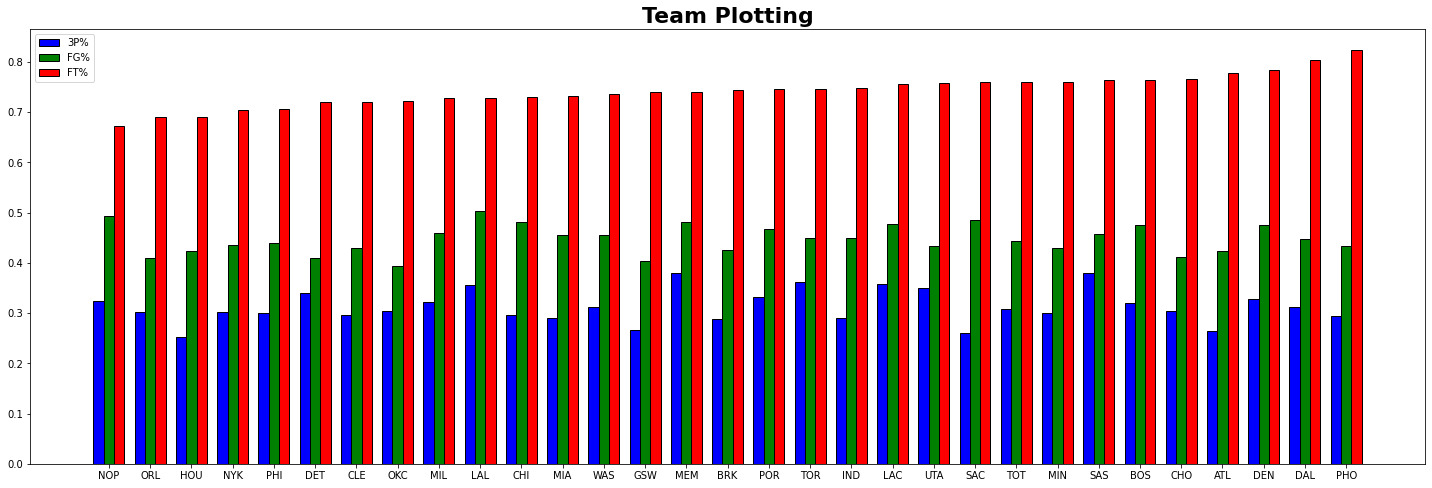

In [19]:
hs = ds[['Tm', 'FT%', 'FG%', '3P%']]
# .plot(kind='bar', figsize=(25,5))
hs = hs.groupby('Tm').mean().sort_values(['FT%'],ascending=True)
hs['Tm'] = hs.index

tm = hs['Tm']
tp = hs['3P%']
ft = hs['FT%']
fg = hs['FG%']
width = 0.25
r = np.arange(len(tm))
  
plt.figure(figsize = (25, 8))
plt.bar(r + width, tp, color = 'blue', width = width, edgecolor = 'black', label='3P%')
plt.bar(r + width + width, fg, color = 'green', width = width, edgecolor = 'black', label='FG%')
plt.bar(r + width + width + width, ft, color = 'red', width = width, edgecolor = 'black', label='FT%')
plt.title('Team Plotting', fontsize = 22, fontweight = 'bold')
plt.xticks(r + width + width, tm)
plt.legend()
  
plt.show()

## 3-Point Percentage

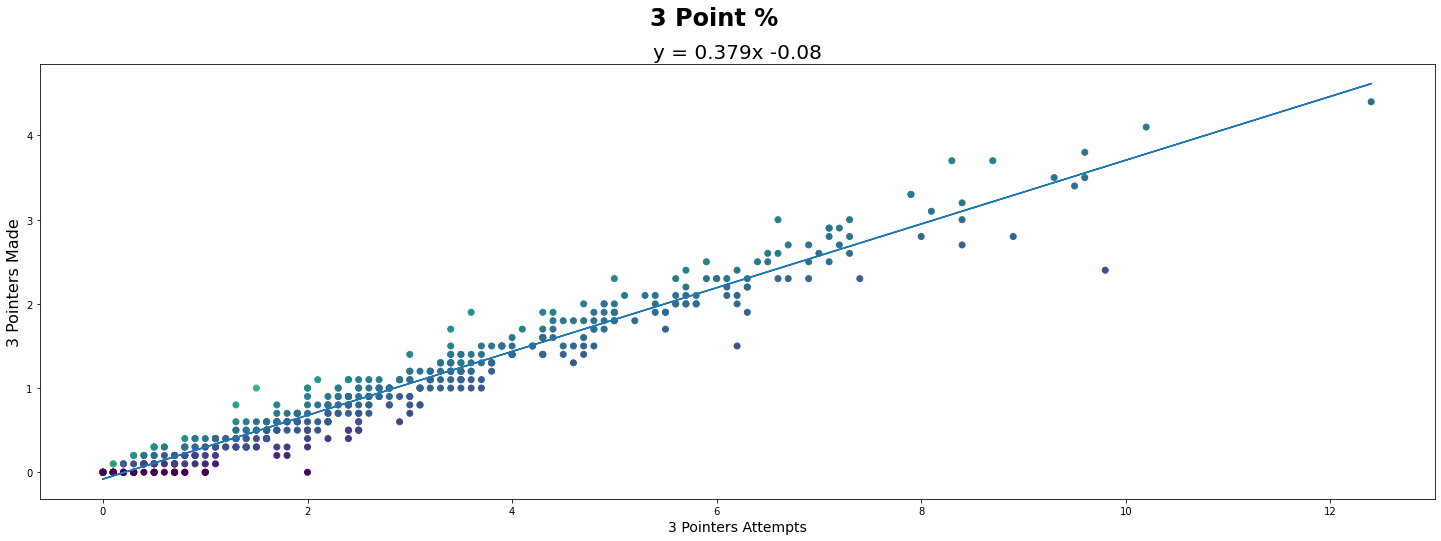

In [106]:
x, y = ds['3PA'], ds['3P']
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.figure(figsize = (25, 8))
plt.plot(x, m*x + b)
plt.scatter(x, y, c = ds['3P%'])
plt.xlabel("3 Pointers Attempts", fontsize = 14)
plt.ylabel("3 Pointers Made", fontsize = 16)
plt.suptitle('3 Point %', fontsize = 24, fontweight = "bold")
plt.title(("y = " + str(round(m, 3)) + "x " + str(round(b, 3))), fontsize = 20)
plt.show()

We find out the one player that averages nearly 13 3-Pointer Attemps (way more than the second in title) is:

In [107]:
print(ds[ds['3PA'] > 12]['Player'])

198    James Harden
Name: Player, dtype: object


## Position Distribution (Shotting above 3-Point %)

Per assumption: Shooting Guards (SG) have the height number of players shooting over the average 3-Point %

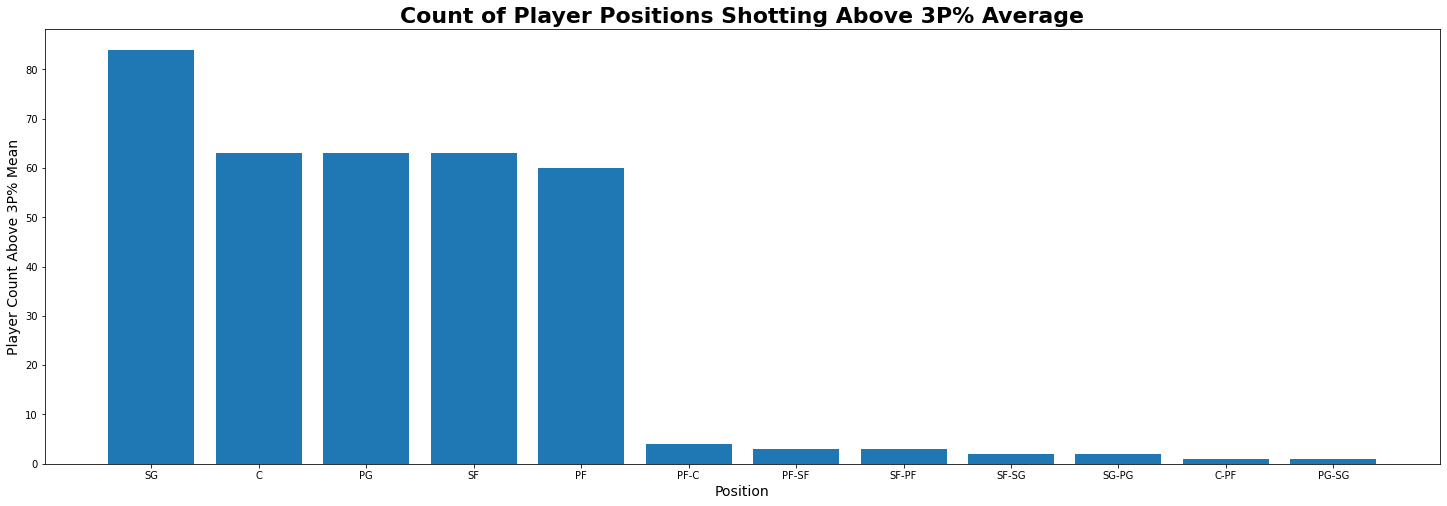

In [108]:
ps = ds[ds['3P%'] >= ds['3P%'].mean()][['Player', 'Pos']]
value_count = ps['Pos'].value_counts()
value_count_indxs = value_count.index
plt.figure(figsize = (25, 8))
plt.bar(value_count_indxs, value_count)
plt.xlabel('Position', fontsize = 14)
plt.ylabel('Player Count Above 3P% Mean', fontsize = 14)
plt.title('Count of Player Positions Shotting Above 3P% Average', fontsize = 22, fontweight = 'bold')
plt.show()

We notice some players have a position labeling of two positions.
Let's try to classify them properly by applying a KNN Algorithm

## Position Classification (KNN)

The black square plots are the players without proper position classification. I applied the KNN modeling algoirthm to the two properties I thought (intuitively) would distinguish players between their positions: 
- Total Rebounds (popular most within C)
- Assists (popular the most within PG)

Commonly Used:  $ k = \frac{\sqrt{n}}{2}$

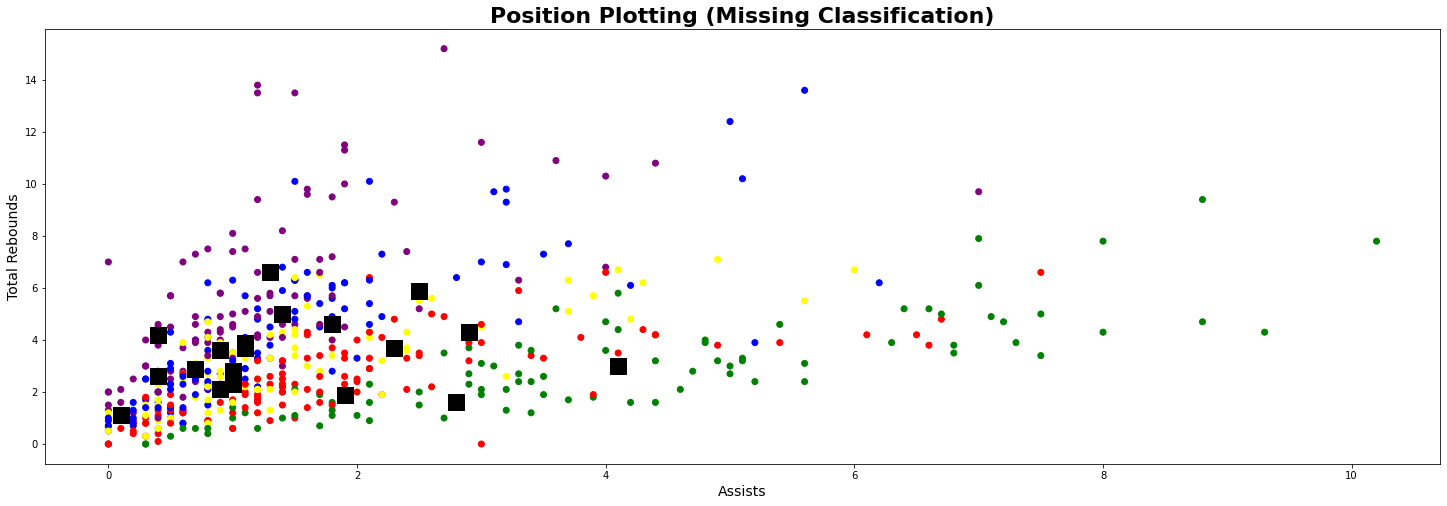

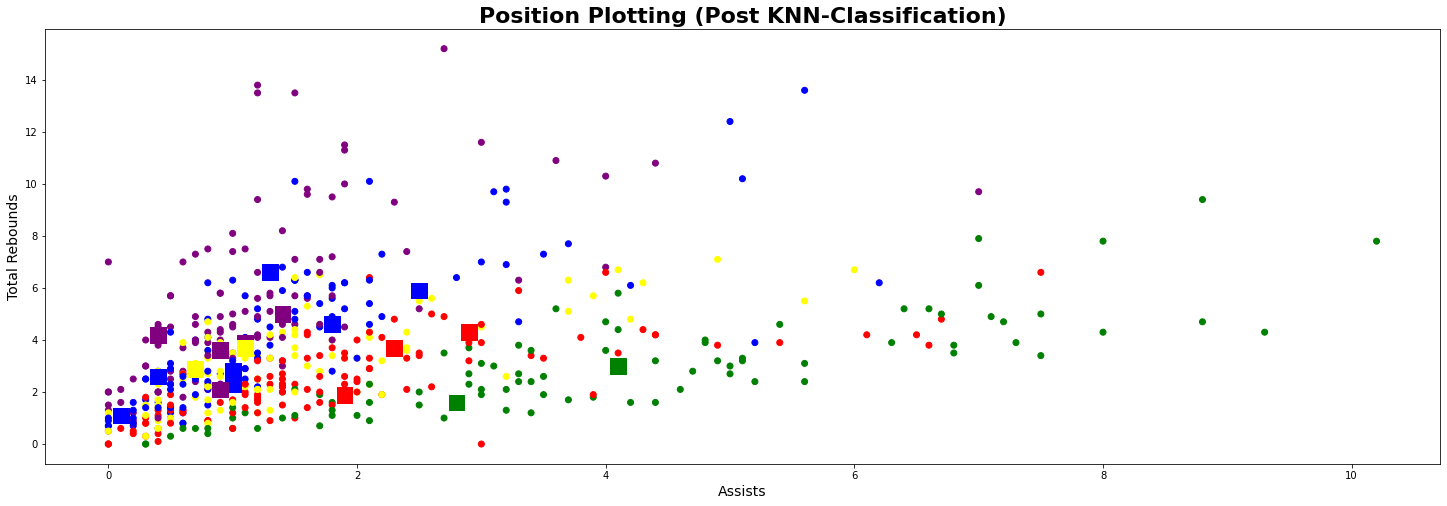

In [5]:

ds_main_pos = ds[ds['Pos'].isin(['SG', 'C', 'PG', 'SF', 'PF'])]
ds_non_main_pos = ds[~ds['Pos'].isin(['SG', 'C', 'PG', 'SF', 'PF'])]
colors = {'SG':'red', 'PG':'green', 'PF':'blue', 'SF':'yellow', 'C':'purple'}

plt.figure(figsize = (25, 8))
plt.scatter(ds_main_pos['AST'], ds_main_pos['TRB'], c = ds_main_pos['Pos'].map(colors))
plt.scatter(ds_non_main_pos['AST'], ds_non_main_pos['TRB'], c = 'black', s = 250, marker = 's')
plt.xlabel('Assists', fontsize = 14)
plt.ylabel('Total Rebounds', fontsize = 14)
plt.title("Position Plotting (Missing Classification)", fontsize = 22, fontweight = 'bold')
plt.show()

knn = KNeighborsClassifier(n_neighbors = int(round(math.sqrt(len(ds_main_pos)))/2))
knn.fit(ds_main_pos[['AST', 'TRB']], ds_main_pos['Pos'])
predictions = knn.predict(ds_non_main_pos[['AST', 'TRB']])

ds_non_main_pos['Pos'] = predictions

plt.figure(figsize = (25, 8))
plt.scatter(ds_main_pos['AST'], ds_main_pos['TRB'], c = ds_main_pos['Pos'].map(colors))
plt.scatter(ds_non_main_pos['AST'], ds_non_main_pos['TRB'], c = ds_non_main_pos['Pos'].map(colors), s = 250, marker = 's')
plt.xlabel('Assists', fontsize = 14)
plt.ylabel('Total Rebounds', fontsize = 14)
plt.title("Position Plotting (Post KNN-Classification)", fontsize = 22, fontweight = 'bold')
plt.show()


#### Is the Model Effective? Test on labeled data.

Accuracy Scores Pre Score: [0.6969697  0.3125     0.67647059 0.15       0.41176471]


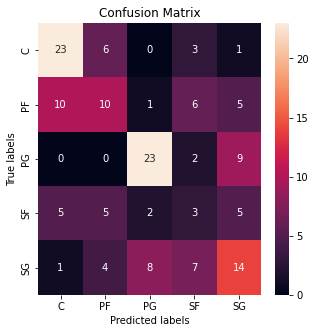

In [21]:
X_train, X_test, y_train, y_test = train_test_split(ds_main_pos[['AST', 'TRB']], ds_main_pos['Pos'], test_size = 0.3, random_state = 42)
knn = KNeighborsClassifier(n_neighbors = int(round(math.sqrt(len(X_train)))/2))
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize = (5, 5))
ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt = 'g', ax = ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['C', 'PF', 'PG', 'SF', 'SG'])
ax.yaxis.set_ticklabels(['C', 'PF', 'PG', 'SF', 'SG'])

# print(classification_report(y_test, predictions, digits = 3, target_names = ['C', 'PF', 'PG', 'SF', 'SG']))
print("Accuracy Scores Pre Score: " + str(cm.diagonal()/cm.sum(axis=1)))


#### Not an effective model:

We see the confusion model, followed by the accuracy scores per position:
- C: 0.700
- PF: 0.313
- PG: 0.678
- SF: 0.150
- SG: 0.412

We conclude that maybe the features selected (AST, TRB) are not effective is predicting the Position labeling (likely causing underfitting)

#### Selecting Features Effectively:

We can use regularization (L2 - Ridge) to give each feature a specific weight.

Text(0.5, 1.0, 'Feature importance using Lasso Model')

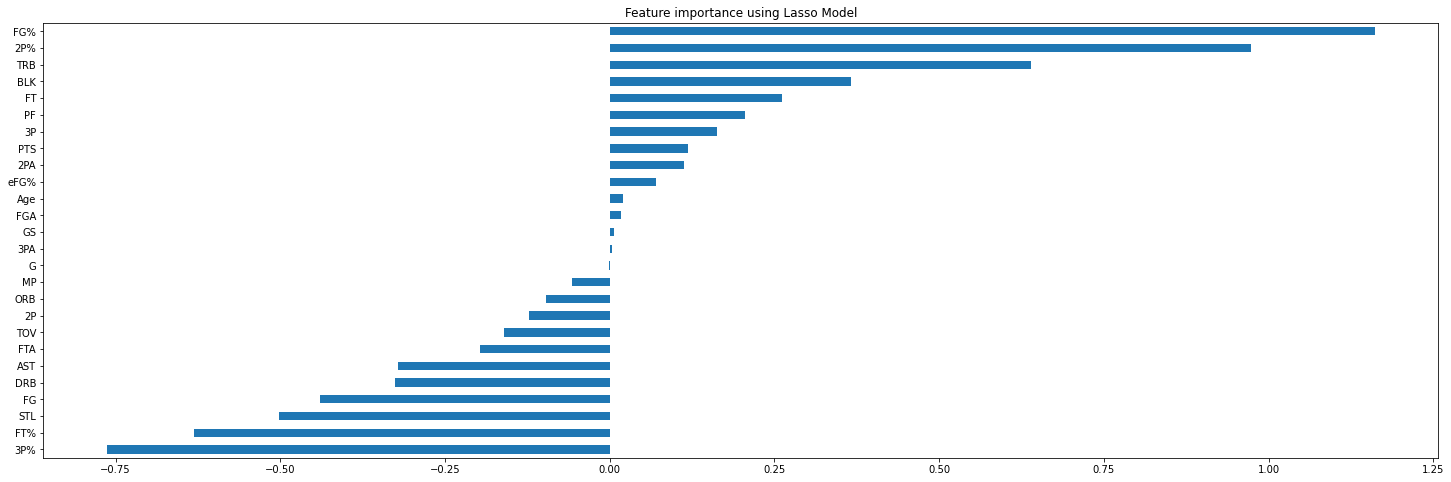

In [7]:
ds_ = ds_main_pos.drop(columns = ['Player', 'Tm'])
ds_['Pos'].replace(['PG', 'SG', 'SF', 'PF', 'C'], [0, 1, 2, 3, 4], inplace = True)

X, y = ds_.drop("Pos", axis = 1), ds_["Pos"]
reg = RidgeCV()
reg.fit(X, y)

plt.figure(figsize = (25, 8))
imp_coef = pd.Series(reg.coef_, index = X.columns).sort_values()
imp_coef.plot(kind = "barh")
matplotlib.rcParams['figure.figsize'] = (15.0, 18.0)
plt.title("Feature importance using Lasso Model")


#### Final Features to use:
- FG%
- 2P%
- TRB
- BLK
- FT

#### Re-Examine KNN Accuracy and Confusion Matrix

Accuracy Scores Pre Score: [0.60606061 0.34375    0.29411765 0.         0.29411765]


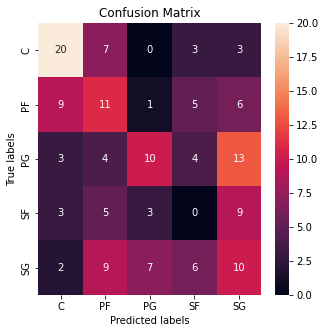

In [22]:
X_train, X_test, y_train, y_test = train_test_split(ds_main_pos[['FG%', '2P%', 'TRB', 'BLK', 'FT']], ds_main_pos['Pos'], test_size = 0.3, random_state = 42)
knn = KNeighborsClassifier(n_neighbors = int(round(math.sqrt(len(X_train)))/2))
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize = (5, 5))
ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt = 'g', ax = ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['C', 'PF', 'PG', 'SF', 'SG'])
ax.yaxis.set_ticklabels(['C', 'PF', 'PG', 'SF', 'SG'])

print("Accuracy Scores Pre Score: " + str(cm.diagonal()/cm.sum(axis=1)))

#### Worst Model:

We see the confusion model, followed by the accuracy scores per position:
- C: 0.601
- PF: 0.348
- PG: 0.294
- SF: 0.000
- SG: 0.294

Maybe the features selected by Regularization algoirthm are mistakening. 

#### Feature Selection Engine (Accuracy Based):
Limiting number of columns to 4

In [25]:
import itertools

def avg_accuracy(acs):
    return round(sum(acs)/len(acs), 2)

def combinations(items):
    return ( set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)) )

cols = ds_main_pos.columns.tolist()
cols = [e for e in cols if e not in ('Pos', 'Tm', 'Player')]
combs = [comb for comb in itertools.combinations(cols, 4)]
max_avg_acc = 0
max_cols = []
for c in combs:
    X_train, X_test, y_train, y_test = train_test_split(ds_main_pos[list(c)], ds_main_pos['Pos'], test_size = 0.3, random_state = 42)
    knn = KNeighborsClassifier(n_neighbors = int(round(math.sqrt(len(X_train)))/2))
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    avg_acc = avg_accuracy(cm.diagonal()/cm.sum(axis=1))
    if max_avg_acc < avg_acc:
        max_avg_acc = avg_acc
        max_cols = c

We learn best columns to result in gear prediction accuracy are
- 3P
- TRB
- AST
- BLK

#### Redesigned Model

Accuracy Scores Pre Score: [0.72727273 0.5        0.70588235 0.2        0.55882353]


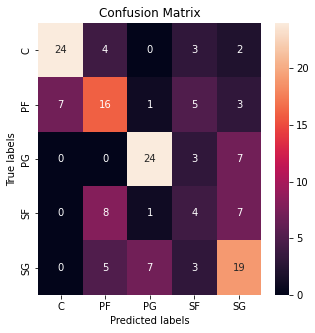

In [23]:
X_train, X_test, y_train, y_test = train_test_split(ds_main_pos[['3P', 'TRB', 'AST', 'BLK']], ds_main_pos['Pos'], test_size = 0.3, random_state = 42)
knn = KNeighborsClassifier(n_neighbors = int(round(math.sqrt(len(X_train)))/2))
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize = (5, 5))
ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt = 'g', ax = ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['C', 'PF', 'PG', 'SF', 'SG'])
ax.yaxis.set_ticklabels(['C', 'PF', 'PG', 'SF', 'SG'])
print("Accuracy Scores Pre Score: " + str(cm.diagonal()/cm.sum(axis=1)))

#### Conclusion:
Optimized 4-feature accuracies:
- C: 0.723
- PF: 0.5
- PG: 0.701
- SF: 0.2
- SG: 0.559

It is difficult to predict a Shotting Forward Position based on its statistics, mainly because of the field it is the most diverse position in terms of skills.

## Relationship (Cluster) Between 3P% and FT%

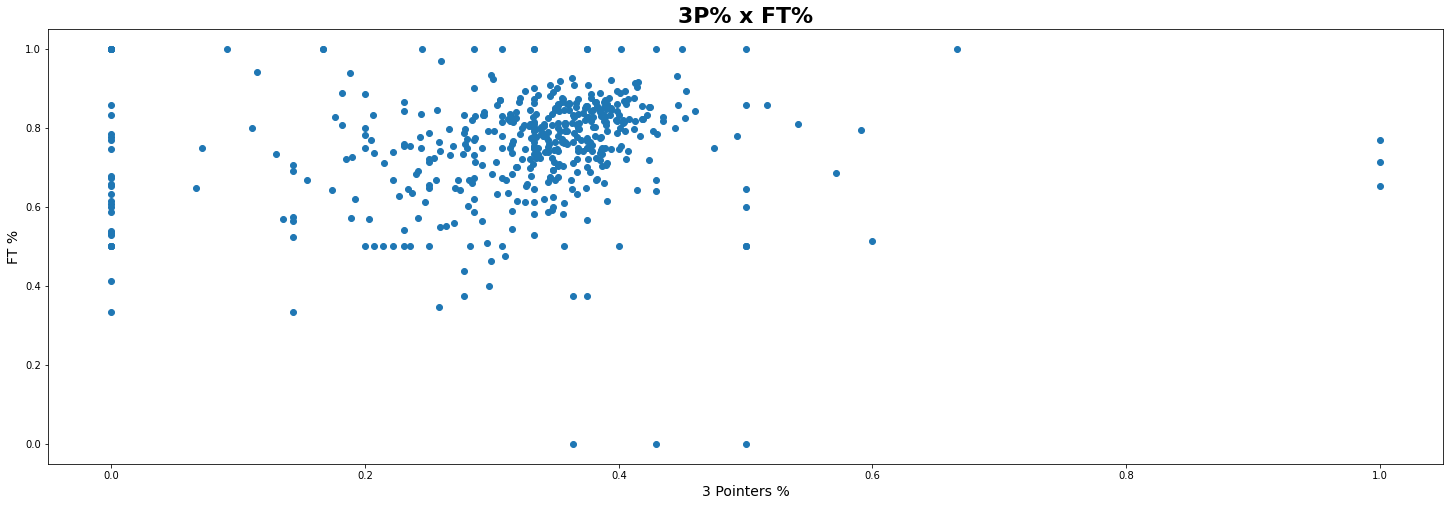

In [10]:
cs = ds[['3P%', 'FT%']]
x, y = ds['3P%'], ds['FT%']
plt.figure(figsize = (25, 8))
plt.scatter(x, y)
plt.xlabel("3 Pointers %", fontsize = 14)
plt.ylabel("FT %", fontsize = 14)
plt.title("3P% x FT%", fontsize = 22, fontweight = 'bold')
plt.show()

Most players fall within one cluster. 

Let us find the anomalies outside of the main cluster.

## Isolation Forrest: Anomaly Detection (3P% x FT%)

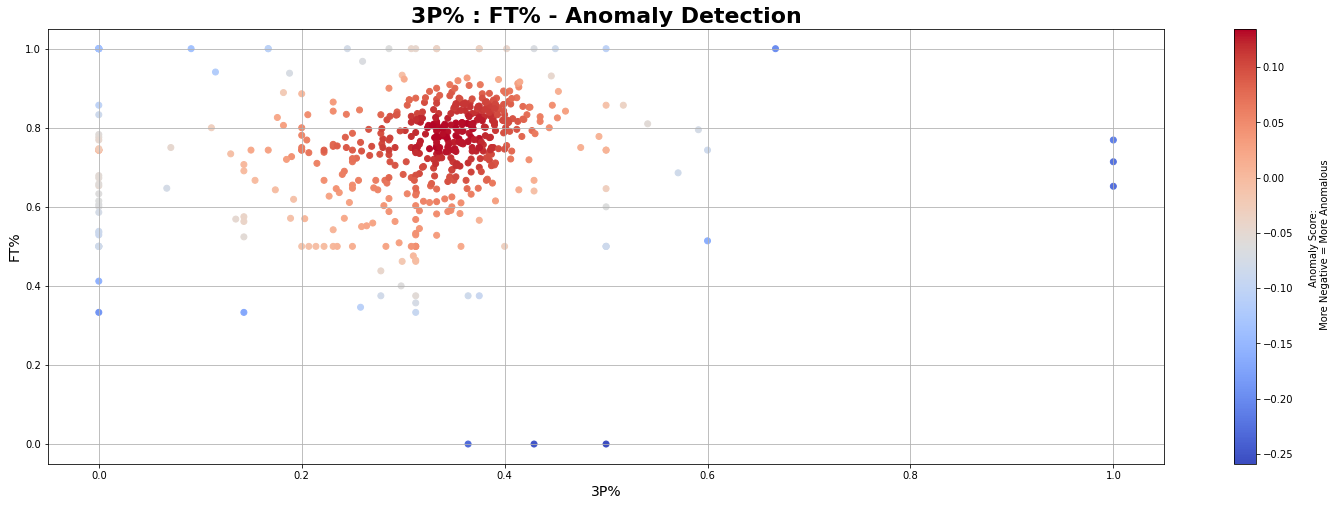

In [111]:
model = ensemble.IsolationForest().fit(cs)
anomaly_score = model.decision_function(cs)
predictions = model.predict(cs)

plt.figure(figsize = (25, 8))
s = plt.scatter(cs['3P%'], cs['FT%'], c = anomaly_score, cmap = 'coolwarm')
plt.colorbar(s, label = '\nAnomaly Score: \n More Negative = More Anomalous')
plt.xlabel('3P%', fontsize = 14)
plt.ylabel('FT%', fontsize = 14)
plt.title('3P% x FT% - Anomaly Detection', fontsize = 22, fontweight = 'bold')
plt.grid()

Each Player was given an anomaly score based on how far it was placed outside of the cluster within our Isolation Forrest Anomaly Detection.

Which players are most anomalous?

#### Most Anomalous Players (3P% x FT%)

In [112]:
anomaly_players = []
for i in range(len(ds)):
    if anomaly_score[i] < 0:
        anomaly_players.append([ds['Player'][i], round(anomaly_score[i], 4)])

ds_ap = pd.DataFrame(anomaly_players, columns =['Player', 'AnoScore']) #anomaly players ds
ds_ap = ds_ap.sort_values('AnoScore')
ds_ap.head(10)

,Player,AnoScore
102,Dean Wade,-0.2589
75,Jeremy Pargo,-0.2499
52,Louis King,-0.2305
7,Tony Bradley,-0.2273
68,Johnathan Motley,-0.2248
27,Drew Eubanks,-0.2125
37,Dusty Hannahs,-0.1987
9,Corey Brewer,-0.1901
54,Vic Law,-0.1683
45,Dwight Howard,-0.1618


## Relationship (Cluster) Between Minutes Played and Field Goal Percentage  MP x FG%

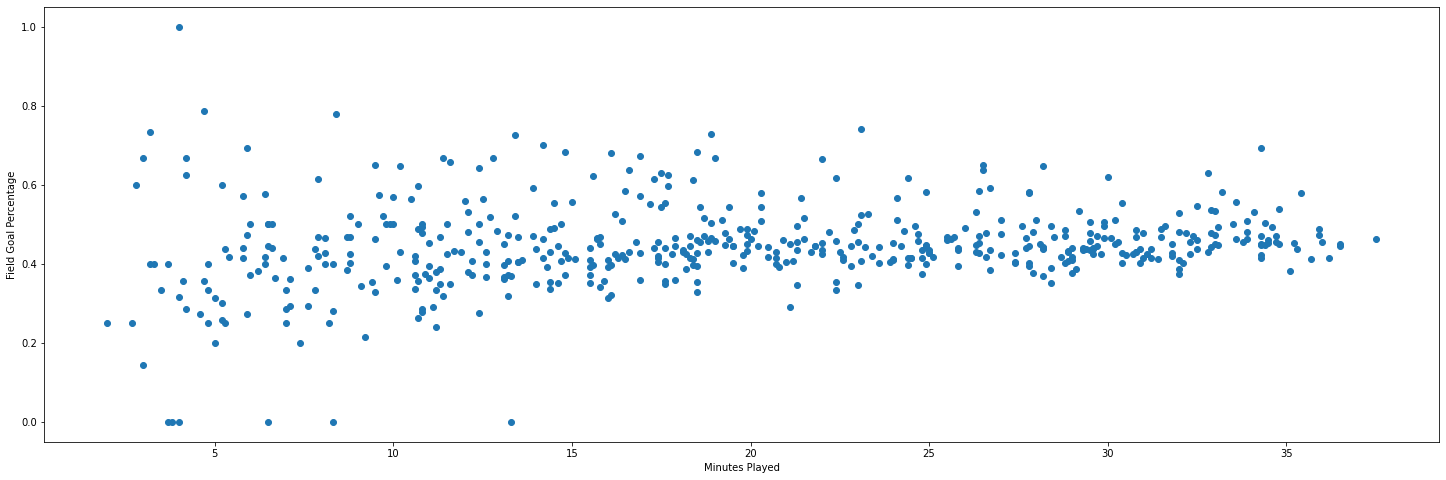

In [123]:
x, y = ds['MP'], ds['FG%']
plt.figure(figsize = (25, 8))
plt.scatter(x, y)
plt.xlabel("Minutes Played")
plt.ylabel("Field Goal Percentage")
plt.show()

## Various Anomaly Detction Methods

#### Support Vector Machine: Anomaly Detection (MP x FG%)

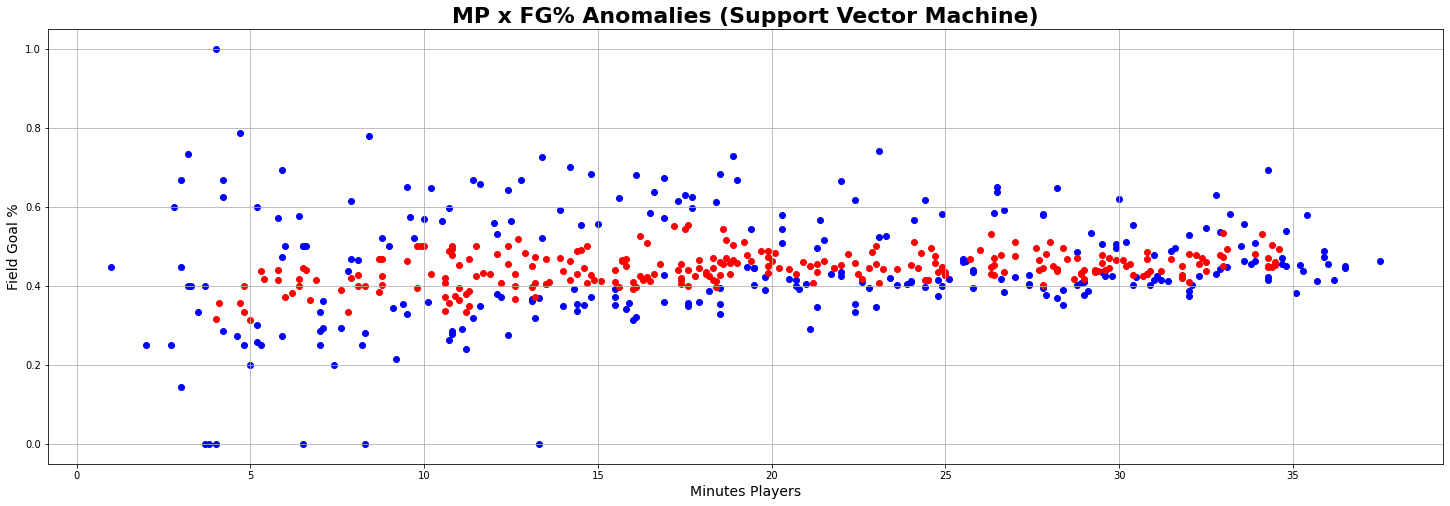

In [135]:
players_ocsvm_ad = ds[["MP", "FG%"]] #OCSVM_AD = One Class Support Vector Machine Anomaly Detection

model = svm.OneClassSVM(kernel='rbf', gamma = 1).fit(players_ocsvm_ad)
model_predictions = model.predict(players_ocsvm_ad)
players_ocsvm_ad['Predicted'] = model_predictions
players_ocsvm_ad
# Make Scatterplot
norms = pd.DataFrame(players_ocsvm_ad[players_ocsvm_ad['Predicted'] == -1])
anoms = pd.DataFrame(players_ocsvm_ad[players_ocsvm_ad['Predicted'] == 1])

plt.figure(figsize = (25, 8))
plt.scatter([norms['MP']], [norms['FG%']], color = 'b')
plt.scatter([anoms['MP']], [anoms['FG%']], color = 'r')
plt.title('MP x FG% Anomalies (Support Vector Machine)', fontsize = 22, fontweight = 'bold')
plt.xlabel('Minutes Players', fontsize = 14)
plt.ylabel('Field Goal %', fontsize = 14)
plt.grid()

Would be beneficial to compare various anomaly detection algoithms
- One Class Support Vector Machine (SVM)
- Isolation Forrest
- Local Outlier Factor
- Elliptic Envelope

#### Isolation Forrest: Anomaly Detection (MP x FG%)

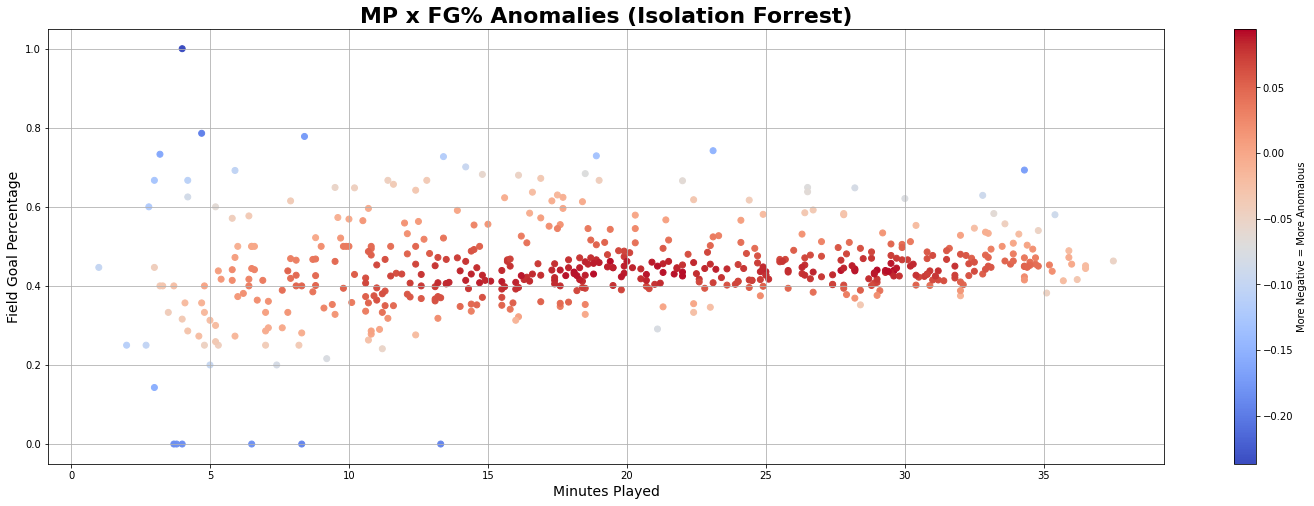

In [138]:
players_ocsvm_ad = ds[["MP", "FG%"]] #OCSVM_AD = One Class Support Vector Machine Anomaly Detection

model = ensemble.IsolationForest().fit(players_ocsvm_ad)
# Get Anomaly Scores and Predictions
anomaly_score = model.decision_function(players_ocsvm_ad)
predictions = model.predict(players_ocsvm_ad)


# ----------------- VISUALIZE -------------------
plt.figure(figsize = (25, 8))
s = plt.scatter(players_ocsvm_ad['MP'], players_ocsvm_ad['FG%'], c = anomaly_score, cmap = 'coolwarm')
plt.colorbar(s, label = 'More Negative = More Anomalous')
plt.xlabel('Minutes Played', fontsize = 14)
plt.ylabel('Field Goal Percentage', fontsize = 14)
plt.title('MP x FG% Anomalies (Isolation Forrest)', fontsize = 22, fontweight = 'bold')
plt.grid()

#### Local Outlier Factor: Anomaly Detection (MP x FG%)

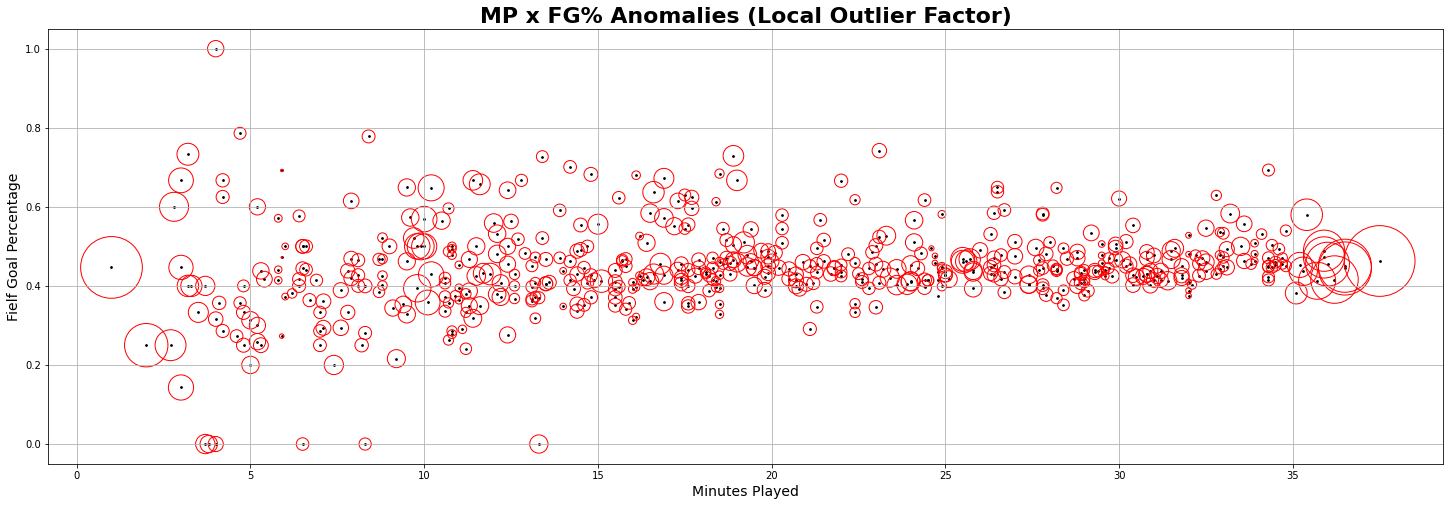

In [139]:
X = ds[["MP", "FG%"]] 
model = LocalOutlierFactor(n_neighbors = 20) #contamination parameter = control how many outliers are desired
predictions = model.fit_predict(X)
ground_truth = [1] * len(X)
n_errors = (predictions != ground_truth).sum()
anomaly_scores = model.negative_outlier_factor_

# plot circles with radius proportional to the outlier scores
radius = ((anomaly_scores.max() - anomaly_scores) / (anomaly_scores.max() - anomaly_scores.min())) * 5

# ----------------- VISUALIZE -------------------
plt.figure(figsize = (25, 8))
plt.title('MP x FG% Anomalies (Local Outlier Factor)', fontsize = 22, fontweight = 'bold')
plt.scatter(X['MP'], X['FG%'], color = "k", s = 3.0, label = "Data points")
plt.scatter( X['MP'], X['FG%'], s = 1000 * radius, edgecolors = "r", facecolors = "none", label = "Outlier scores")
plt.xlabel('Minutes Played', fontsize = 14)
plt.ylabel('Fielf Goal Percentage', fontsize = 14)
plt.grid()


#### Elliptic Envelope: Anomaly Detection (MP x FG%)

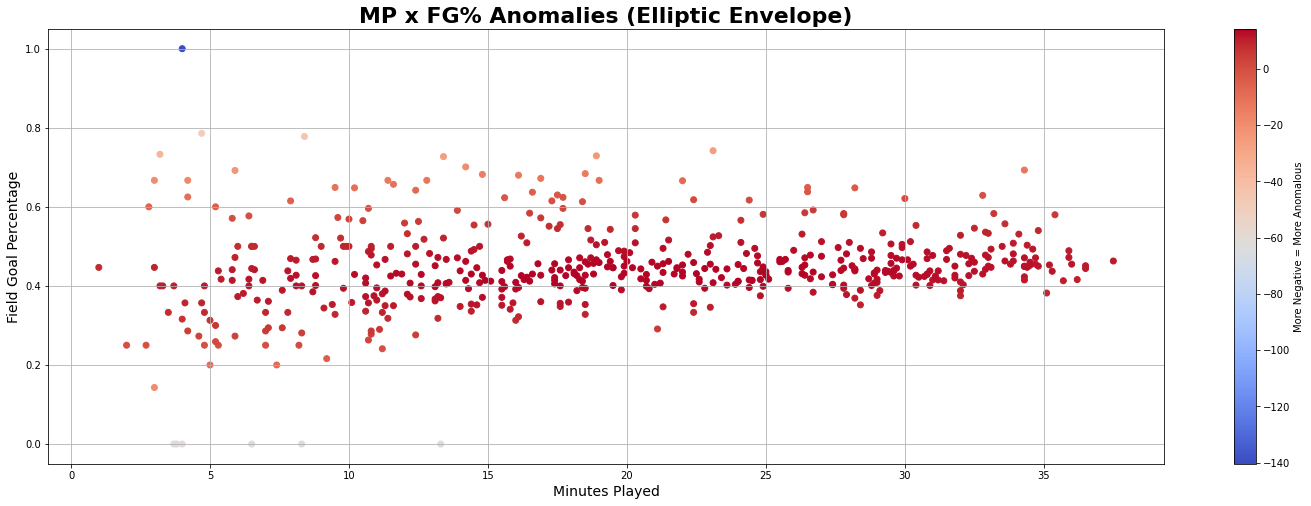

In [140]:
X = ds[["MP", "FG%"]] 
model = EllipticEnvelope()

model.fit(X)
anomaly_scores = model.decision_function(X)
predictions = model.predict(X)

# ----------------- VISUALIZE -------------------
plt.figure(figsize = (25, 8))
plt.title("LOCAL OUTLIER FACTOR (LOF)", fontsize = 18, weight = 'bold')
s = plt.scatter(X['MP'], X['FG%'], c = anomaly_scores, cmap = 'coolwarm')
plt.colorbar(s, label = 'More Negative = More Anomalous')
plt.xlabel('Minutes Played', fontsize = 14)
plt.ylabel('Field Goal Percentage', fontsize = 14)
plt.title('MP x FG% Anomalies (Elliptic Envelope)', fontsize = 22, fontweight = 'bold')
plt.grid()


# All Actions: 2020 - 2021 Season

In [113]:
ds = pd.read_csv('actions.csv')

#### Missing Values Impute

In [130]:
players = pd.read_csv('players.csv')  
for i in players.columns:
    try:
        players[i].fillna(value=players[i].mean(), inplace=True)
    except:
        pass

We shall begin with basic analysis

#### Leading 20 Players (Steals)

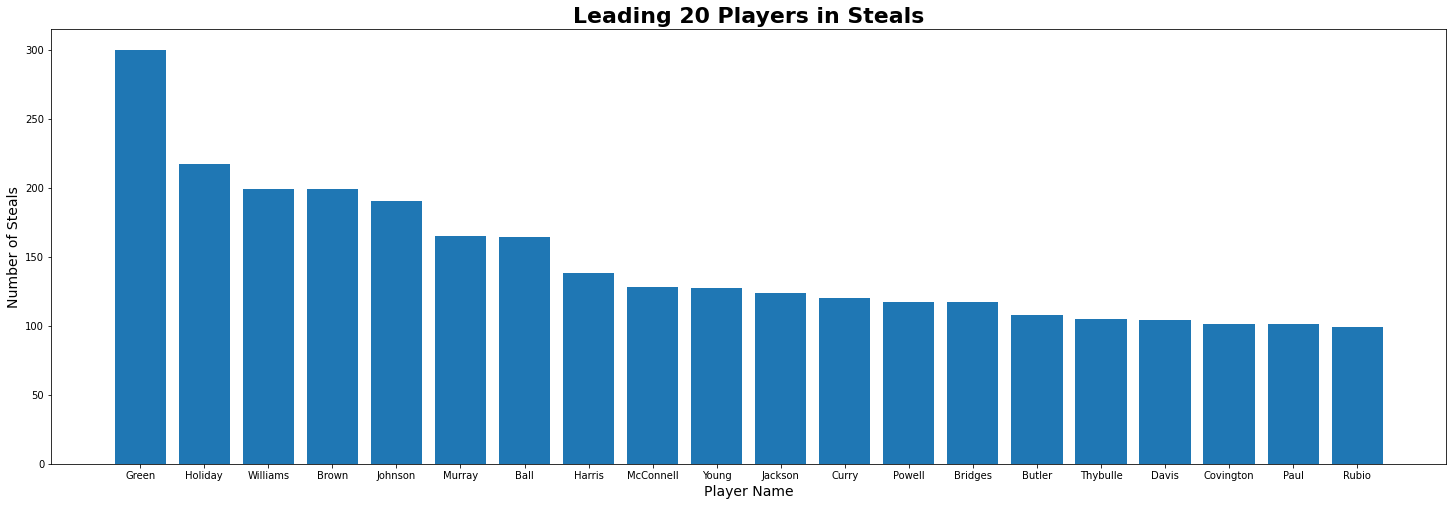

In [114]:
plt.figure(figsize = (25, 8))
ds_ = ds["stealPlayerName"].value_counts()[:20]
plt.bar(ds_.index, ds_)
plt.xlabel('Player Name', fontsize = 14)
plt.ylabel('Number of Steals', fontsize = 14)
plt.title('Leading 20 Players in Steals', fontsize = 22, fontweight = 'bold')
plt.show()

#### Leading 20 Players (Block)

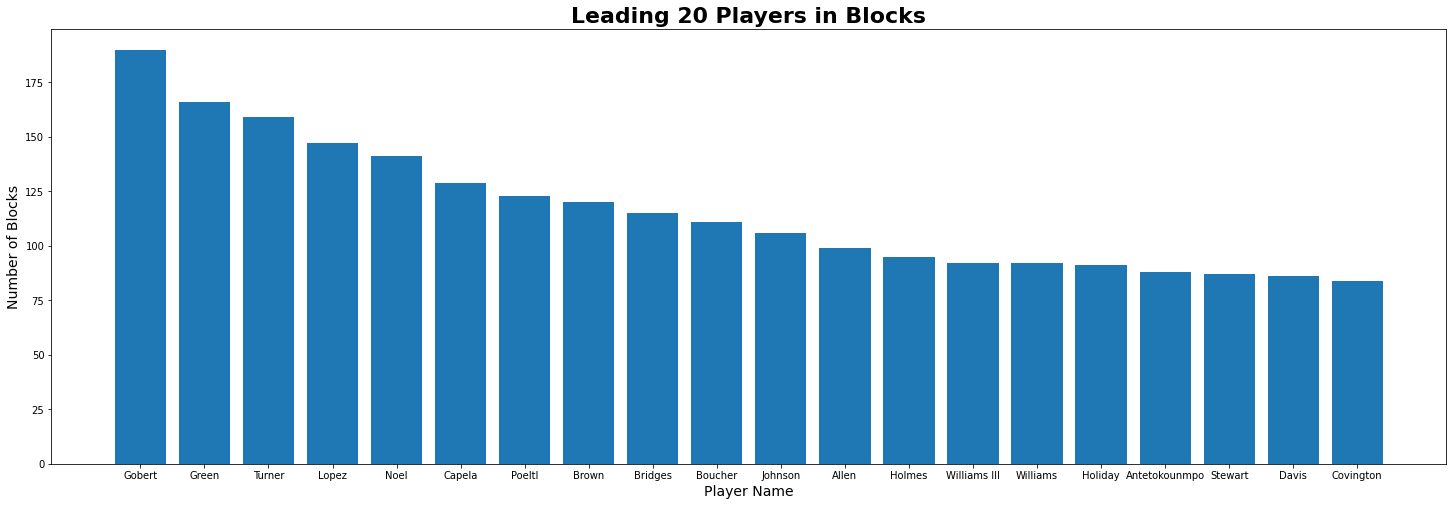

In [115]:
plt.figure(figsize = (25, 8))
ds_ = ds["blockPlayerName"].value_counts()[:20]
plt.bar(ds_.index, ds_)
plt.xlabel('Player Name', fontsize = 14)
plt.ylabel('Number of Blocks', fontsize = 14)
plt.title('Leading 20 Players in Blocks', fontsize = 22, fontweight = 'bold')
plt.show()

#### Leading 20 Players (Jump Balls)

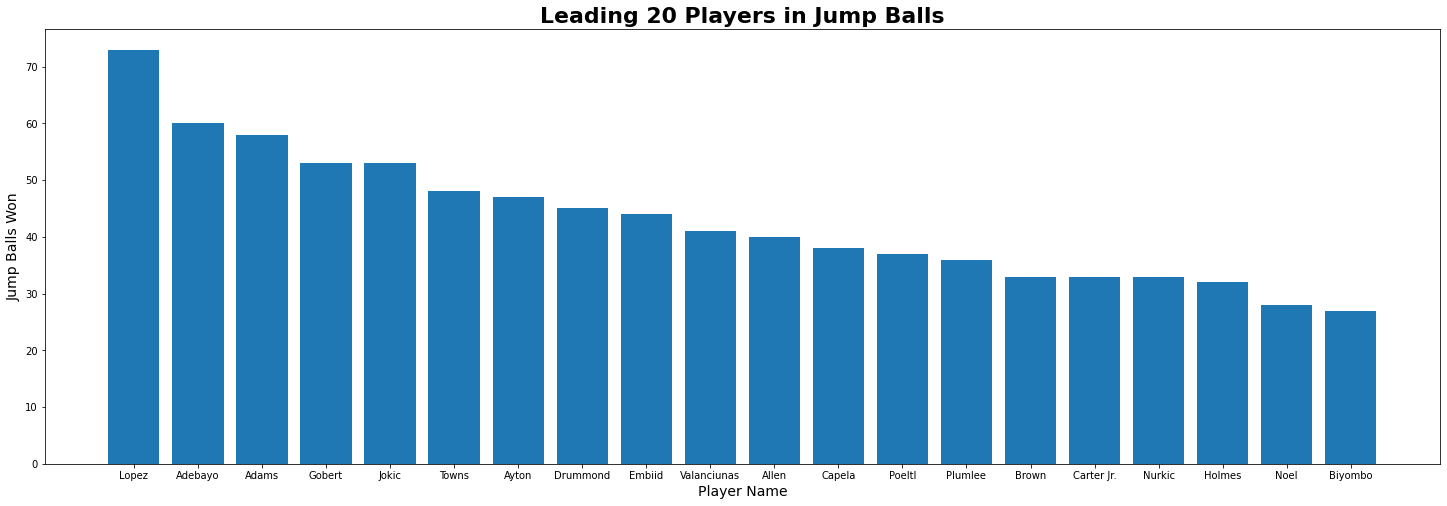

In [116]:
plt.figure(figsize = (25, 8))
ds_ = ds['jumpBallWonPlayerName'].value_counts()[:20]
plt.bar(ds_.index, ds_)
plt.xlabel('Player Name', fontsize = 14)
plt.ylabel('Jump Balls Won', fontsize = 14)
plt.title('Leading 20 Players in Jump Balls', fontsize = 22, fontweight = 'bold')
plt.show()

Returning to James Harden who is shooting an absurd number of three pointers every game (surprisngly keeping a good percentage)

We will attemp to calculate his percntage per spot on the court while also comparing his statistics to the rest of the league

#### James Harden: Court Location Shooting Percentage

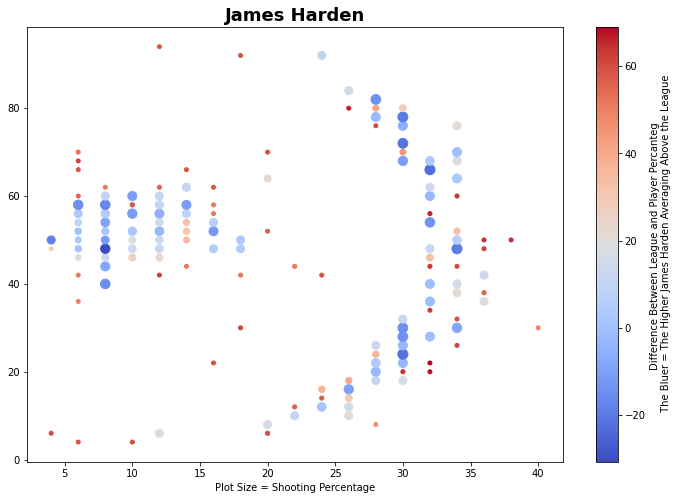

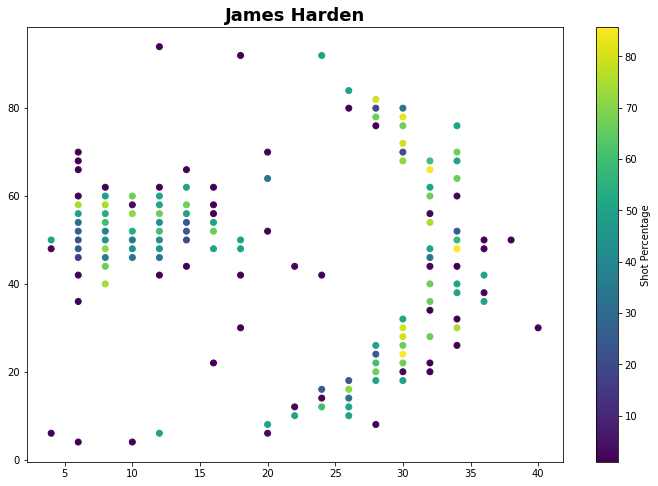

In [89]:
def minimizeGeoShots(x, base):
    return base * round(x/base)

def convertCourtOneSided(ds):
    for i, x, y in zip(ds.index, ds['x'], ds['y']):
        if x > 50:
            ds.loc[i , 'x'] = 100 - x
            ds.loc[i , 'y'] = 100 - y
    return ds

ds = pd.read_csv('actions.csv')
ds = ds[['actionType', 'x', 'y', 'playerName', 'shotResult']]
ds_ = ds.loc[(ds['actionType'].isin(['3pt', '2pt']))]
ds = ds.loc[(ds['actionType'].isin(['3pt', '2pt'])) & (ds['playerName'] == 'Harden')]

def calcXYshotAvg(ds):
    ds['x'], ds['y'] = list(map(lambda x: minimizeGeoShots(x, 2), ds['x'])), list(map(lambda x: minimizeGeoShots(x, 2), ds['y']))
    ds = convertCourtOneSided(ds)
    ds = ds.groupby(['x', 'y', 'shotResult'], as_index = False)['actionType'].count()
    ds.columns = ['x','y','result', 'count']
    ds_miss = ds[ds['result'] == 'Missed']
    ds = ds[ds['result'] == 'Made']
    ds.drop('result', axis = 1, inplace = True)
    for x, y, c in zip(ds_miss['x'], ds_miss['y'], ds_miss['count']):
        if ((ds['x'] == x) & (ds['y'] == y)).any():
            made, miss = ds[(ds['x'] == x) & (ds['y'] == y)]['count'], c
            ds.loc[(ds['x'] == x) & (ds['y'] == y), 'count'] = 100 - round((100 * (made / (made + miss))), 2)
        else:
            pd.concat([ds, pd.DataFrame([x, y, -c])], axis = 0, ignore_index = True)
    return ds

ds_ = calcXYshotAvg(ds_)
ds = calcXYshotAvg(ds)

ds['diffLg'] = [0] * len(ds) #create default column
# --- add column for difference between player and league average
for x, y, c in zip(ds_['x'], ds_['y'], ds_['count']):
    if ((ds['x'] == x) & (ds['y'] == y)).any():
        player, league = ds[(ds['x'] == x) & (ds['y'] == y)]['count'], c
        ds.loc[(ds['x'] == x) & (ds['y'] == y), 'diffLg'] = league - player
plt.figure(figsize = (12, 8))
plt.title("James Harden", fontsize = 18, weight = 'bold')
plt.xlabel('Plot Size = Shooting Percentage')
s = plt.scatter(ds['x'], ds['y'], s = 15 + (ds['count']), c = ds['diffLg'] , cmap = 'coolwarm', marker = 'o')
cbar = plt.colorbar(s, label = 'Difference Between League and Player Percanteg \n The Bluer = The Higher James Harden Averaging Above the League')
plt.show()

plt.figure(figsize = (12, 8))
plt.title("James Harden", fontsize = 18, weight = 'bold')
s = plt.scatter(ds['x'], ds['y'], c = ds['count'], cmap = 'viridis', marker = 'o')
cbar = plt.colorbar(s, label = 'Shot Percentage')
plt.show()